In [1]:
import math
import numpy
from matplotlib import animation
import matplotlib.pyplot as plt
from numba import cuda

%matplotlib notebook

In [2]:
@cuda.jit
def quadCoeffCompute(uvals,P,Q,R,vjsqrinv,quadCoeffs,JLvals,JRvals,JSize):
    i = cuda.grid(1)
    invI = JSize-i-1
    quadCoeffs[i] = i
    if i == 0:
        quadCoeffs[i] = (2*uvals[0] - 5*uvals[1]+4*uvals[2] - uvals[3])*vjsqrinv
    elif i == JSize-1:
        quadCoeffs[i] = (2*uvals[-1] - 5*uvals[-2]+4*uvals[-3] - uvals[-4])*vjsqrinv
        #print(quadCoeffs[i])
    else:
        quadCoeffs[i] = (uvals[i-1] -2*uvals[i]+uvals[i+1])*vjsqrinv
    
    cuda.syncthreads()
    
    if i != 0:
        JLvals[i] = P*uvals[i] + Q*uvals[i-1] + quadCoeffs[i]*R
        #print( P,uvals[i], Q, uvals[i-1], quadCoeffs[i-1],R, i , JLvals[i])
    if i<JSize - 1:
        JRvals[invI-1] = P*uvals[invI-1]+Q*uvals[ invI ] + R*quadCoeffs[invI]
        #print(P,uvals[invI-1],Q,uvals[ invI ],R,quadCoeffs[invI],i)

In [3]:
def uniform_gf_quad(fvals, xvals , alpha):

    JLval = [0]     
    JRval = [0]
    
    #assume uniform step size
    h = xvals[1] - xvals[0]
    
    size = len(xvals)    
    
    vj    = alpha*h
    dj    = math.exp(-vj) 
    ratio = (1-dj)/vj
    eps = 1e-3
    Q     = -dj + ratio
    
    #if things get small, this blows up 
    if vj>eps:
        P = 1 - ratio
        R = 1-dj-vj/2*(1+dj )
    else:

        P = (h/2-nu**2/6+h**3/24-h**4/120)
        R = -math.exp(-h/2)*(h**3/12+h**5/480+h**7/53760)
    
    threadsperblock = 64
    blocks = int(size/threadsperblock)
    vjsqrinv = 1/vj**2
    quadCoeffs = numpy.zeros(size)
    JLval      = numpy.zeros(size)
    JRval      = numpy.zeros(size)
    quadCoeffCompute[blocks,threadsperblock](numpy.array(fvals), 
                                             P,Q,R, 
                                             vjsqrinv , 
                                             quadCoeffs, 
                                             JLval,
                                             JRval,
                                             int(size))
    #JRvaltot = JRval[::-1]
    #print(JRval)
    #quadCoeffs = []
    #for i in range(size):
    #    if i != 0 and i != (size-1):
    #        quadCoeffs.append((fvals[i-1] -2*fvals[i] + fvals[i+1])*1/vj**2 )
    #    elif i == 0:
    #        quadCoeffs.append((2*fvals[0] -5*fvals[1] +4*fvals[2] - fvals[3])*1/vj**2 )
    #    else:
    #        quadCoeffs.append((2*fvals[-1] -5*fvals[-2] +4*fvals[-3] - fvals[-4])*1/vj**2)
    #evaluate the polynomial integral for each J between 0 and N.
    for j in range(size):
        
        if j != 0:
            #recursive formula to update the value of J
            #JLcurr  = P*fvals[j] + Q*fvals[j-1] + quadCoeffs[j-1]*R
            JLval[j] = dj*JLval[j-1] + JLval[j] 
        if j != size-1:
            JRval[-(j+2)] = (dj*JRval[-(j+1)] + JRval[-(j+2)])
    
    
    #print(JRval)
    #print(JLval)
    #JRval = JRval[::-1]
    return [JLval[i] + JRval[i] for i in range(size)]


<IPython.core.display.Javascript object>


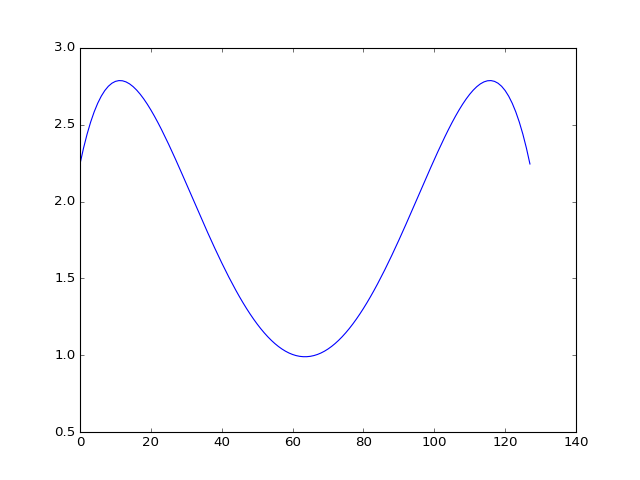

In [4]:
xvals = numpy.linspace(-2,2,64*2)
fvals = [x**2 for x in xvals]
alpha = 1.5625
z = uniform_gf_quad(fvals,xvals,alpha)
plt.plot(z)
plt.show()

In [5]:

T = 5
N = 64
a = -1
b = 1

x = numpy.linspace(a,b,N)

CFL = 1
c = 2

dx = x[1]-x[0]
dt = dx/c*CFL

beta = 2
alpha = beta /(c*dt)

f = lambda x: math.exp(-72*((x-(a+b)/2)/(b-a))**2)
g = lambda x: 144/(b-a)**2*(x-(a+b)/2)*math.exp(  -72*( (x-(a+b)/2) / (b-a) )**2)

u0 = [f(xi) for xi in x ]
#u1 = [f(xi) + dt*g(xi) for xi in x]
u1 = [1/2*(f(xi-c*dt)+ f(xi+c*dt) + dt*(g(xi-c*dt)+g(xi+c*dt))) for xi in x]
#u1[0] = (u1[0]+u1[-1])/2
#u1[-1] = u1[0]
t0 = 0

Ga = [math.exp(-alpha*(xi-a)) for xi in x]
Gb = [math.exp(-alpha*(b-xi)) for xi in x]
dN = math.exp(-alpha*(b-a))

vL = [(Ga[i]-dN*Gb[i])/(1-dN**2) for i in range(len(Ga))]
vR = [(Gb[i]-dN*Ga[i])/(1-dN**2) for i in range(len(Ga))]

uSoln = [u0,u1]

while t0<T:
    w = uniform_gf_quad(u1,x,alpha)
    wsize = len(w)
    #should probably all happen in one or two loops
    #w = [w[i] - w[-1]*vL[i] - w[0]*vR[i] for i in range(wsize)]
    w = [u1[i] -.5*w[i] for i in range(wsize)]
    u = [2*u1[i] - u0[i]-beta**2*w[i] for i in range(wsize)]
    u0 = u1
    u1 = u
    uSoln.append(u)
    t0+=dt

In [6]:
def animate(i):
    line.set_data(x,uSoln[i])
    return line,
def init():
    line.set_data([], [])
    return line,    

<IPython.core.display.Javascript object>


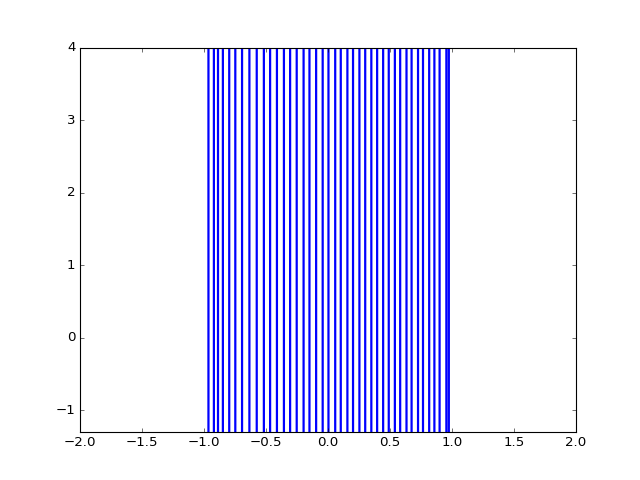

In [18]:
fig   = plt.figure()
ax    = plt.axes(xlim=(-2,2),ylim = (-1.3,4))
line, = ax.plot([],[] , lw=2)
anim = animation.FuncAnimation(fig,animate, frames = len(uSoln),interval=20,blit=True)
